In [264]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as p
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.gridspec import GridSpec
from scipy.stats import pearsonr
from scipy.spatial import distance
from scipy.stats.mstats import gmean
from sklearn.linear_model import LinearRegression
%matplotlib inline
from itertools import combinations
from itertools import chain

from multiprocessing import Pool
import sys
import os
import copy
sns.set_style('white')
sns.set_style('ticks')
sns.set_color_codes()

fgm_simulation_path = '/Users/grantkinsler/Documents/Stanford/Research/StarryNight/Git/starry-night/Simulations/FGM_simulation_callable.py'
sys.path.append(os.path.dirname(os.path.expanduser(fgm_simulation_path)))
from FGM_simulation_callable import simulation, nball_pull, gaussian_fitness

tools_path = '../code/tools.py'
graphs_path = '../code/graphs.py'
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
sys.path.append(os.path.dirname(os.path.expanduser(graphs_path)))
import tools
import graphs
from tools import mutant_colorset
from tools import condition_colorset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
cov_thresh = 1e6

fitness_data = p.read_csv('../data/DoubleBC_Merged_Fitness_Atish_Weighted_Default_AllConditions_IncludingOld_swapsremoved.csv')

merged_fitness_data = fitness_data

In [3]:
mutant_train_set = p.read_csv('../data/mutant_train_set.csv')
training_bcs = mutant_train_set['barcode'].values

mutant_minimal_train_set = p.read_csv('../data/mutant_minimal_train_set.csv')
minimal_training_bcs = mutant_minimal_train_set['barcode'].values

mutant_minimal_train_set = p.read_csv('../data/mutant_minimal_test_set.csv')
minimal_testing_bcs = mutant_minimal_train_set['barcode'].values

In [170]:
# old_conditions = {
#                   '3':['3.1','3.2','3.3'],
#                   '6':['6.1','6.2','6.3'],
#                   '13':['13.1','13.2','13.3'],
#                   '18':['18.1','18.2','18.3'],
#                   '20':['20.1','20.2','20.3'],
#                   '21':['21.1','21.2','21.3'],
#                   '23':['23.1','23.2','23.3']
#                  }

# bigbatch_conditions = {
#                         '1BB_M3':['A','B','C','D'],
#                         '1BB_Baffle':['E','F'],
#                         '1BB_1.4%Gluc' :['G','H'],
#                         '1BB_1.8%Gluc' :['I','J'],
#                         '1BB_0.2MNaCl' :['K','L'],
# #                         '1BB_0.2MNaCl' :['K'], 
#                         '1BB_0.5MNaCl' :['M','N'],
#                         '1BB_0.2MKCl' :['O'],
#                         '1BB_0.5MKCl' :['P'],
#                         '1BB_8.5uMGdA' :['Q','R'],
#                         '1BB_17uMGdA' :['S','T'],
#                         '1BB_2ugFlu' :['U','V'],
#                         '1BB_0.5ugFlu' :['W','X'],
#                         '1BB_1%Raf' :['Y','Z'],
#                         '1BB_0.5%Raf' :['AA','BB'],
#                         '1BB_1%Gly' :['CC','DD'],
#                         '1BB_1%EtOH' :['EE','FF'],
#                         '1BB_SucRaf' :['GG'],
#                       }

old_conditions = {
#                   '3':['t3.1','t3.2','t3.3'],
#                   '6':['t6.1','t6.2','t6.3'],
#                   '13':['t13.1','t13.2','t13.3'],
#                   '18':['t18.1','t18.2','t18.3'],
                  '19':['t19.1','t19.2','t19.3'],
#                   '20':['t20.1','t20.2','t20.3'],
#                   '21':['t21.1','t21.2','t21.3'],
#                   '23':['t23.1','t23.2','t23.3'],
                  'M3_Batch_3':['3.1','3.2','3.3'],
                  'M3_Batch_6':['6.1','6.2','6.3'],
                  'M3_Batch_13':['13.1','13.2','13.3'],
                  'M3_Batch_18':['18.1','18.2','18.3'],
#                   'M3_Batch_19':['t19.1','t19.2','t19.3'],
                  'M3_Batch_20':['20.1','20.2','20.3'],
                  'M3_Batch_21':['21.1','21.2','21.3'],
                  'M3_Batch_23':['23.1','23.2','23.3'],

                    ## radicicol
                    ## benomyl
                    ## fluconazole
                    ## Glucose gradient
    
    }

bigbatch_conditions = {
                        '1BB_M3':['A','B','C','D'],
                        '1BB_Baffle':['E','F'],
                        '1BB_1.4%Gluc' :['G','H'],
                        '1BB_1.8%Gluc' :['I','J'],
                        '1BB_0.2MNaCl' :['K','L'],
#                         '1BB_0.2MNaCl' :['K'], 
                        '1BB_0.5MNaCl' :['M','N'],
                        '1BB_0.2MKCl' :['O'],
                        '1BB_0.5MKCl' :['P'],
                        '1BB_8.5uMGdA' :['Q','R'],
                        '1BB_17uMGdA' :['S','T'],
                        '1BB_2ugFlu' :['U','V'],
                        '1BB_0.5ugFlu' :['W','X'],
                        '1BB_1%Raf' :['Y','Z'],
                        '1BB_0.5%Raf' :['AA','BB'],
                        '1BB_1%Gly' :['CC','DD'],
                        '1BB_1%EtOH' :['EE','FF'],
                        '1BB_SucRaf' :['GG'],
                      }



# old_nonm3_conditions = [
# #     '1.4Glucose', '1.6Glucose', '1.7Glucose', '1.8Glucose',
#        '2.5Glucose', '24_Hour_Transfer_PC', 'Benomyl_2ug/mL',
#        'DMSO', 'Ferm_40_Hour_Transfer', 'Ferm_44_Hour_Transfer',
#        'Ferm_50_Hour_Transfer', 'Ferm_54_Hour_Transfer',
#        'Fluconazole_2ug/mL', 'Geldanamycin8.5uM','Radicicol_5uM', 'Resp_5_Day_Transfer',
#        'Resp_7_Day_Transfer']

old_nonm3_conditions = {'Ferm_44hr_Transfer':['t14.1','t14.2','t14.3'],
                  'Ferm_40hr_Transfer':['t15.1','t15.2','t15.3'],
                  'Ferm_54hr_Transfer':['t16.1','t16.2','t16.3'],
                  'Ferm_50hr_Transfer':['t17.1','t17.2','t17.3'],
                  'Resp_24hr_Transfer':['t5.1','t5.2','t5.3'],
                  'Resp_3Day_Transfer':['t7.1','t7.2','t7.3'],
                  'Resp_4Day_Transfer':['t8.1','t8.2','t8.3'],
                  'Resp_5Day_Transfer':['t25.1','t25.2','t25.3'],
                  'Resp_6Day_Transfer':['t26.1','t26.2','t26.3'],
                  'Resp_7Day_Transfer':['t27.1','t27.2','t27.3'],
                  'DMSO':['t1.1','t1.2','t1.3'],
                  'Geldanamycin8.5uM':['t2.4','t2.5','t2.6'],}




# m3_conditions = {**old_conditions,}
conditions = {**old_conditions, **bigbatch_conditions}
conditions = {**conditions, **old_nonm3_conditions}
all_conditions = conditions.keys()
all_reps = [rep for reps in conditions.values() for rep in reps]

m3_conditions = list(old_conditions.keys()) + ['1BB_M3']
m3_reps = [rep for condition in m3_conditions for rep in conditions[condition]]



In [5]:
diploid_mean = np.mean(merged_fitness_data[merged_fitness_data['gene']=='Diploid']['1BB_M3_fitness'])
diploid_std = np.std(merged_fitness_data[merged_fitness_data['gene']=='Diploid']['1BB_M3_fitness'])

mutation_type = []
for entry in range(len(merged_fitness_data.index)):
    gene_name = merged_fitness_data['gene'].values[entry]
    this_type = merged_fitness_data['type'].values[entry]
    m3_fitness = merged_fitness_data['1BB_M3_fitness'].values[entry]
    if gene_name == 'IRA1':
        if this_type == 'missense_variant':
            mutation_type.append('IRA1_missense')
        elif this_type in ['frameshift_variant','stop_gained']:
            mutation_type.append('IRA1_nonsense')
        else:
            mutation_type.append('IRA1_other')
    elif gene_name == 'Diploid':
        if m3_fitness > diploid_mean+2*diploid_std:
            mutation_type.append('Diploid_adaptive')
        else:
            mutation_type.append('Diploid')
        
    else:
        mutation_type.append(gene_name)
        
            
merged_fitness_data['mutation_type'] = mutation_type

In [6]:
full_neutral_list = [17615,18486,42040,45014,58284,63611,73731,74185,80465,94896
,120600,125697,132511,134852,135750,190551,228237,238783,255561,298344
,308537,316954,317346,335717,411685,454359,469053] 

### from previous list but never has fitness above 3.5% (per gen) in any of 5000bc experiments
supergood_neutral = [17615, 24362, 42040, 71926, 72939, 73802, 80465, 109476, 113483, 
                     134852, 135750, 238783, 263665, 276406, 316954, 335717, 454359] 

### pulled from supergood list and spiked into 1BigBatch experiments
neutral_spikes = [17615,24362,42040,71926,73802,109476,113483,134852,263665,316954]

# neutrals = full_neutral_list
neutrals = list(np.unique(full_neutral_list+supergood_neutral+neutral_spikes))

In [7]:
this_data = merged_fitness_data
this_data = this_data.replace([np.inf, -np.inf], np.nan)
# this_data = this_data.dropna('columns',how='all')
this_data = this_data.dropna()

this_data = this_data.sort_values('barcode')

m3_cols = [col + '_fitness' for col in m3_conditions]
m3_conditions = m3_cols

nonm3_cols = [col + '_fitness' for col in bigbatch_conditions.keys() if (col + '_fitness') not in m3_cols]
nonm3_cols = nonm3_cols + [col + '_fitness' for col in old_nonm3_conditions.keys()]
nonm3_conditions = nonm3_cols

fitness_cols = m3_cols + nonm3_cols

fitness = this_data[fitness_cols].values

n_mutants = fitness.shape[0]
n_conditions = fitness.shape[1]


([<matplotlib.axis.YTick at 0x119e0c198>,
 <a list of 6 Text yticklabel objects>)

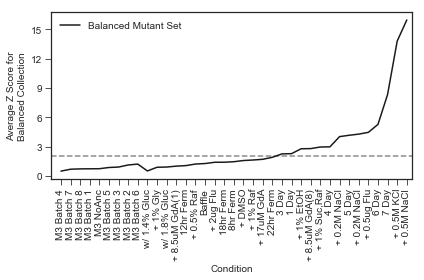

In [171]:
used_mutants = [bc for bc in this_data['barcode'].values if bc in (list(minimal_training_bcs) + list(minimal_testing_bcs))]
      
all_mut_locs = sorted(list(np.where(np.isin(this_data['barcode'].values,used_mutants))[0]))


m3_means = np.nanmean(this_data[m3_cols].values[all_mut_locs,:],axis=1)
m3_stds = np.nanstd(this_data[m3_cols].values[all_mut_locs,:],axis=1)

repeated_means = np.repeat(m3_means,len(nonm3_cols)).reshape(len(m3_means),len(nonm3_cols))
repeated_stds = np.repeat(m3_stds,len(nonm3_cols)).reshape(len(m3_stds),len(nonm3_cols))
nonm3_z_scores = np.abs((this_data[nonm3_cols].values[all_mut_locs,:]-repeated_means)/repeated_stds)

repeated_means = np.repeat(m3_means,len(m3_cols)).reshape(len(m3_means),len(m3_cols))
repeated_stds = np.repeat(m3_stds,len(m3_cols)).reshape(len(m3_stds),len(m3_cols))
m3_z_scores = np.abs((this_data[m3_cols].values[all_mut_locs,:]-repeated_means)/repeated_stds)

mean_m3_z_scores = m3_z_scores
mean_nonm3_z_scores = nonm3_z_scores

sorted_nonm3_cols = np.asarray(nonm3_cols)[np.argsort(np.mean(nonm3_z_scores,axis=0))]
sorted_m3_cols = np.asarray(m3_cols)[np.argsort(np.mean(m3_z_scores,axis=0))]
plt.plot(sorted(np.mean(m3_z_scores,axis=0))+sorted(np.mean(nonm3_z_scores,axis=0)),'-',color='k',alpha=1.0,label='Balanced Mutant Set')

all_cols = list(sorted_m3_cols)+list(sorted_nonm3_cols)
plt.xticks(range(len(all_cols)),[renamed_conditions[col.split('_fitness')[0]] for col in (all_cols)],rotation=90)

plt.legend()
# plt.ylim(0,7)
plt.xlim(-1,len(m3_conditions)+len(nonm3_conditions)-0.5)
plt.ylabel('Average Z Score for\nBalanced Collection')
plt.xlabel('Condition')

plt.tight_layout()
plt.axhline(2,color='k',linestyle='--',alpha=0.5)
plt.yticks(range(0,16,3),range(0,16,3))
# plt.savefig('z_scores_minimal_comparison.pdf',bbox_inches='tight')

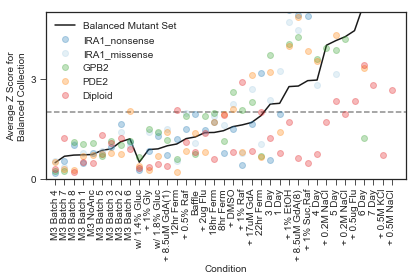

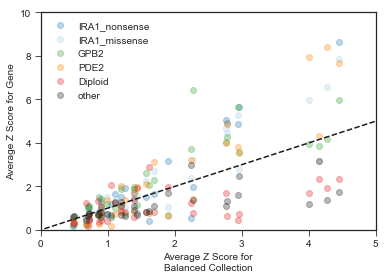

In [172]:
used_mutants = [bc for bc in this_data['barcode'].values if bc in (list(minimal_training_bcs) + list(minimal_testing_bcs))]
      
all_mut_locs =sorted(list(np.where(np.isin(this_data['barcode'].values,used_mutants))[0]))

m3_means = np.nanmean(this_data[m3_cols].values[all_mut_locs,:],axis=1)
m3_stds = np.nanstd(this_data[m3_cols].values[all_mut_locs,:],axis=1)

repeated_means = np.repeat(m3_means,len(nonm3_cols)).reshape(len(m3_means),len(nonm3_cols))
repeated_stds = np.repeat(m3_stds,len(nonm3_cols)).reshape(len(m3_stds),len(nonm3_cols))
nonm3_z_scores = np.abs((this_data[nonm3_cols].values[all_mut_locs,:]-repeated_means)/repeated_stds)

repeated_means = np.repeat(m3_means,len(m3_cols)).reshape(len(m3_means),len(m3_cols))
repeated_stds = np.repeat(m3_stds,len(m3_cols)).reshape(len(m3_stds),len(m3_cols))
m3_z_scores = np.abs((this_data[m3_cols].values[all_mut_locs,:]-repeated_means)/repeated_stds)

allgenes_m3_z_scores = m3_z_scores
allgenes_nonm3_z_scores = nonm3_z_scores

sorted_nonm3_cols = np.asarray(nonm3_cols)[np.argsort(np.mean(nonm3_z_scores,axis=0))]
sorted_m3_cols = np.asarray(m3_cols)[np.argsort(np.mean(m3_z_scores,axis=0))]
plt.plot(sorted(np.mean(m3_z_scores,axis=0))+sorted(np.mean(nonm3_z_scores,axis=0)),'-',color='k',alpha=1.0,label='Balanced Mutant Set')

all_cols = list(sorted_m3_cols)+list(sorted_nonm3_cols)
plt.xticks(range(len(all_cols)),[renamed_conditions[col.split('_fitness')[0]] for col in (all_cols)],rotation=90)


plt.legend()
# plt.ylim(0,7)
plt.xlim(-1,len(m3_conditions)+len(nonm3_conditions)+0.5)
plt.ylabel('Average Z Score for\nBalanced Collection')
plt.xlabel('Condition')

plt.tight_layout()
plt.axhline(2,color='k',linestyle='--',alpha=0.5)
plt.yticks(range(0,16,3),range(0,16,3))

plt.savefig('z_scores_minimal_comparison.pdf',bbox_inches='tight')



gene_list = ['IRA1','GPB2','PDE2','Diploid']
gene_list = ['IRA1_nonsense','IRA1_missense','GPB2','PDE2','Diploid']
for gene in gene_list:
    
    used_mutants = [bc for bc in this_data[this_data['mutation_type']==gene]['barcode'].values]
    this_gene_locs =sorted(list(np.where(np.isin(this_data['barcode'].values,used_mutants))[0]))
    
    m3_means = np.nanmean(this_data[m3_cols].values[this_gene_locs,:],axis=1)
    m3_stds = np.nanstd(this_data[m3_cols].values[this_gene_locs,:],axis=1)

    repeated_means = np.repeat(m3_means,len(nonm3_cols)).reshape(len(m3_means),len(nonm3_cols))
    repeated_stds = np.repeat(m3_stds,len(nonm3_cols)).reshape(len(m3_stds),len(nonm3_cols))
    thisgene_nonm3_z_scores = np.abs((this_data[nonm3_cols].values[this_gene_locs,:]-repeated_means)/repeated_stds)

    repeated_means = np.repeat(m3_means,len(m3_cols)).reshape(len(m3_means),len(m3_cols))
    repeated_stds = np.repeat(m3_stds,len(m3_cols)).reshape(len(m3_stds),len(m3_cols))
    thisgene_m3_z_scores = np.abs((this_data[m3_cols].values[this_gene_locs,:]-repeated_means)/repeated_stds)

    sorted_nonm3_cols = np.asarray(nonm3_cols)[np.argsort(np.mean(allgenes_nonm3_z_scores,axis=0))]
    sorted_m3_cols = np.asarray(m3_cols)[np.argsort(np.mean(allgenes_m3_z_scores,axis=0))]
    plt.plot(list(np.mean(thisgene_m3_z_scores,axis=0)[np.argsort(np.mean(allgenes_m3_z_scores,axis=0))])+
              list(np.mean(thisgene_nonm3_z_scores,axis=0)[np.argsort(np.mean(allgenes_nonm3_z_scores,axis=0))])
             ,'o',color=mutant_colorset[gene],alpha=0.3,label=gene)
plt.legend()

plt.savefig('z_scores_minimal_comparison_plusmore.pdf',bbox_inches='tight')

plt.ylim(0,5)
plt.savefig('z_scores_minimal_comparison_plusmore_zoomed.pdf',bbox_inches='tight')   


gene_list = ['IRA1','GPB2','PDE2','Diploid']
gene_list = ['IRA1_nonsense','IRA1_missense','GPB2','PDE2','Diploid','other']

mean_std_bygene = {}

plt.figure()
for gene in gene_list:
    
#     plt.figure()
    
#     plt.title(gene)
    
    used_mutants = [bc for bc in this_data[this_data['mutation_type']==gene]['barcode'].values]
    this_gene_locs =sorted(list(np.where(np.isin(this_data['barcode'].values,used_mutants))[0]))
    
    m3_means = np.nanmean(this_data[m3_cols].values[this_gene_locs,:],axis=1)
    m3_stds = np.nanstd(this_data[m3_cols].values[this_gene_locs,:],axis=1)

    repeated_means = np.repeat(m3_means,len(nonm3_cols)).reshape(len(m3_means),len(nonm3_cols))
    repeated_stds = np.repeat(m3_stds,len(nonm3_cols)).reshape(len(m3_stds),len(nonm3_cols))
    thisgene_nonm3_z_scores = np.abs((this_data[nonm3_cols].values[this_gene_locs,:]-repeated_means)/repeated_stds)

    repeated_means = np.repeat(m3_means,len(m3_cols)).reshape(len(m3_means),len(m3_cols))
    repeated_stds = np.repeat(m3_stds,len(m3_cols)).reshape(len(m3_stds),len(m3_cols))
    thisgene_m3_z_scores = np.abs((this_data[m3_cols].values[this_gene_locs,:]-repeated_means)/repeated_stds)
    
    mean_std_bygene[gene] = [np.mean(m3_means),np.mean(m3_stds)]


    sorted_nonm3_cols = np.asarray(nonm3_cols)[np.argsort(np.mean(allgenes_nonm3_z_scores,axis=0))]
    sorted_m3_cols = np.asarray(m3_cols)[np.argsort(np.mean(allgenes_m3_z_scores,axis=0))]
    
    plt.plot((list(np.mean(allgenes_m3_z_scores ,axis=0)[np.argsort(np.mean(allgenes_m3_z_scores ,axis=0))])+
              list(np.mean(allgenes_nonm3_z_scores,axis=0)[np.argsort(np.mean(allgenes_nonm3_z_scores,axis=0))])),
             (list(np.mean(thisgene_m3_z_scores,axis=0)[np.argsort(np.mean(allgenes_m3_z_scores ,axis=0))])+
              list(np.mean(thisgene_nonm3_z_scores,axis=0)[np.argsort(np.mean(allgenes_nonm3_z_scores,axis=0))]))
             ,'o',color=mutant_colorset[gene],alpha=0.3,label=gene)
xmin,xmax = plt.xlim()
ymin,ymax = plt.ylim()
onetoone = [min([xmin,ymin]),max([xmax,ymax])]
plt.plot(onetoone,onetoone,'k--')
plt.legend()
plt.xlabel('Average Z Score for\nBalanced Collection')
plt.ylabel('Average Z Score for Gene')
plt.xlim(0,20)
plt.savefig('z_score_comparison_allgenes.pdf')

plt.xlim(0,5)
plt.ylim(0,10)
plt.savefig('z_score_comparison_allgenes_zoomed.pdf')
    
    




KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

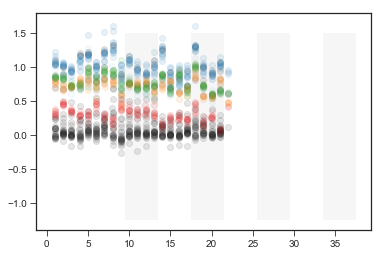

In [191]:
# test_mutant_data = this_data[~this_data['barcode'].isin(minimal_training_bcs)]

mutant_data = this_data[this_data['barcode'].isin((list(minimal_training_bcs)+list(minimal_testing_bcs)))]

m3_conditions = sorted_m3_cols
nonm3_conditions = sorted_nonm3_cols


this_gene = ['GPB2','PDE2','IRA1','Diploid','other']
this_gene = ['IRA1_nonsense','IRA1_missense','GPB2','PDE2','Diploid','other']
# this
this_gene_data = mutant_data[mutant_data['mutation_type'].isin(this_gene)]


this_gene_locs = np.where(np.isin(mutant_data['barcode'].values,this_gene_data['barcode'].values))[0]
jitters = [tools.jitter_point(0,0.01) for bc in range(len(this_gene_data[m3_conditions[0]].values)) ]

plt.figure()
fig,ax = plt.subplots()

for i in range(7):
    if (i % 2) == 0:
#         print(i)
        rect = matplotlib.patches.Rectangle((len(m3_conditions)+1+4*i-0.5,ymin),4,ymax-ymin,
                                        linewidth=0,edgecolor='gray',facecolor='gray',alpha=0.07)
    
        ax.add_patch(rect)

# plt.title(f'Predictions with {rank+1} components')
for i,col in enumerate(m3_conditions):
    for bc in range(len(this_gene_data[col].values)):
        plt.scatter([i + 1 + jitters[bc]],this_gene_data[col].values[bc],alpha=0.1,color=mutant_colorset[this_gene_data['mutation_type'].values[bc]]) 

for i,col in enumerate(nonm3_conditions):
    for bc in range(len(this_gene_data[col].values)):
        plt.scatter([len(m3_conditions)+i + 1 + jitters[bc]],this_gene_data[col].values[bc],alpha=0.1,color=mutant_colorset[this_gene_data['mutation_type'].values[bc]]) 

for gene in this_gene:
    this_gene_data = mutant_data[mutant_data['mutation_type']==gene]
    data = np.median(np.asarray([this_gene_data[col].values for col in (list(m3_conditions) + list(nonm3_conditions))]),axis=1)
    plt.plot(range(1,len((list(m3_conditions) + list(nonm3_conditions)))+1),data,alpha=1.0,color=mutant_colorset[gene],label=gene)

plt.axvline(x=len(m3_conditions)+0.5,color='gray')
# plt.legend()
plt.xticks(range(1,len(m3_conditions)+len(nonm3_conditions)+1),[renamed_conditions[col.split('_fitness')[0]] for col in (list(m3_conditions) + list(nonm3_conditions))],rotation=90)


plt.xlim(0.0,len(m3_conditions)+len(nonm3_conditions)+0.5)
plt.ylabel('Relative Fitness')
plt.xlabel('Condition')



plt.savefig('relative_fitness_line_dots_noylim.pdf',bbox_inches='tight')

plt.ylim(-0.5,1.8)


plt.savefig('relative_fitness_line_dots.pdf',bbox_inches='tight')

plt.ylim(-1.25,1.5)
plt.yticks(np.linspace(ymin,ymax,12),np.linspace(ymin,ymax,12))

plt.savefig('relative_fitness_line_dots_matchedylim.pdf',bbox_inches='tight')



In [ ]:
plt.subplots(2,2,figsize=(2*8,2*6))

ax = plt.subplot(221)
gene_list = ['IRA1_nonsense','IRA1_missense','GPB2','PDE2','Diploid','other']

# this_gene = ['IRA1_nonsense','IRA1_missense','GPB2','PDE2','Diploid','other']
graphs.fitness_featured_genes_figure(ax,this_data,minimal_training_bcs,minimal_testing_bcs,m3_conditions,nonm3_conditions,gene_list,ymin=-1.25,ymax=1.5,yticknum=12)

ax = plt.subplot(222)

gene_list = ['IRA1_nonsense','IRA1_missense','GPB2','PDE2','Diploid']
graphs.fitness_tubes_graph(ax,this_data,mean_std_bygene,minimal_training_bcs,minimal_testing_bcs,m3_conditions,nonm3_conditions,gene_list)

# plt.tight_layout() # only off when tight layout is used - might need to annotate afterwards



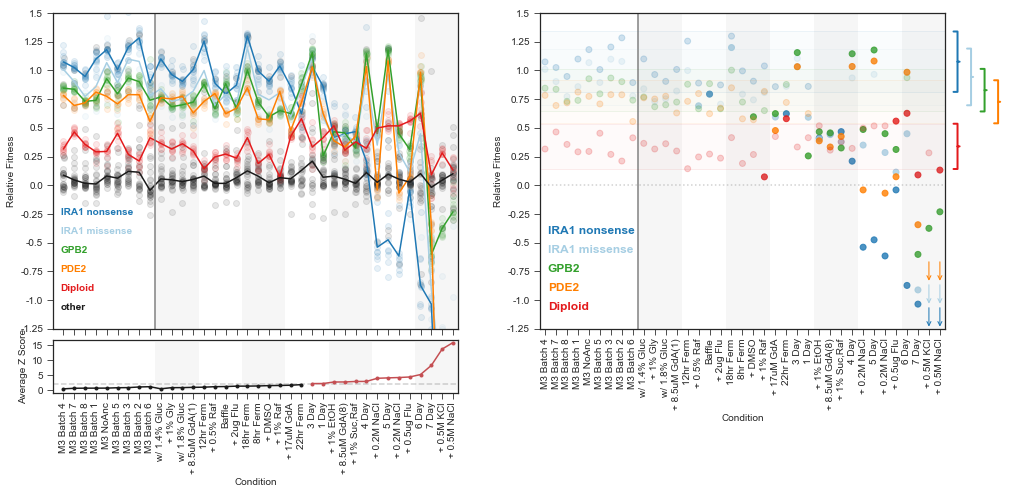

In [292]:
fig = plt.figure(figsize=(2*8,2*6+1))
gs = GridSpec(3, 2, width_ratios=[1, 1], height_ratios=[6, 1, 6],hspace=0.05)

ax1 = fig.add_subplot(gs[0])

gene_list = ['IRA1_nonsense','IRA1_missense','GPB2','PDE2','Diploid','other']

# this_gene = ['IRA1_nonsense','IRA1_missense','GPB2','PDE2','Diploid','other']
graphs.fitness_featured_genes_figure(ax1,this_data,minimal_training_bcs,minimal_testing_bcs,m3_conditions,nonm3_conditions,gene_list,ymin=-1.25,ymax=1.5,yticknum=12)

# plt.xticks()
plt.xlabel('')

ax2 = fig.add_subplot(gs[1])

gene_list = ['IRA1_nonsense','IRA1_missense','GPB2','PDE2','Diploid']
graphs.fitness_tubes_graph(ax2,this_data,mean_std_bygene,minimal_training_bcs,minimal_testing_bcs,m3_conditions,nonm3_conditions,gene_list)

                 
ax3 = fig.add_subplot(gs[2])

graphs.zscore_graph(ax3,m3_z_scores,nonm3_z_scores,sorted_m3_cols,sorted_nonm3_cols)



# plt.tight_layout() # only off when tight layout is used - might need to annotate afterwards


0
2
4
6
IRA1_nonsense 0.812983203204337 1.3391275966984706 0.5261443934941336
20.800879440248075
2.104577573976534
IRA1_missense 0.6962759515247393 1.1902442527038808 0.4939683011791415
19.528812256071372
1.975873204716566
GPB2 0.642547228120301 1.0133281331508863 0.37078090503058536
14.65865454360918
1.4831236201223414
PDE2 0.5391003088723267 0.9142906295433473 0.37519032067102054
14.832978786673948
1.5007612826840822
Diploid 0.14111853521874482 0.5354624976624761 0.39434396244373127
15.59020930795726
1.577375849774925
[432. 288.]


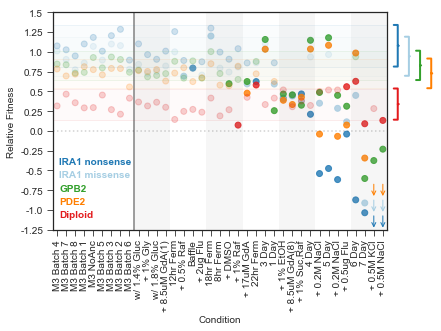

In [256]:
# test_mutant_data = this_data[~this_data['barcode'].isin(minimal_training_bcs)]

ymin = -1.25
ymax = 1.5

mutant_data = this_data[this_data['barcode'].isin((list(minimal_training_bcs)+list(minimal_testing_bcs)))]

m3_conditions = sorted_m3_cols
nonm3_conditions = sorted_nonm3_cols


this_gene = ['GPB2','IRA1','PDE2','Diploid']
this_gene = ['IRA1_nonsense','IRA1_missense','GPB2','PDE2','Diploid']

offset = {'IRA1_nonsense':0,
          'IRA1_missense':0.1/3,
          'Diploid':0,
          'GPB2':0.2/3,
          'PDE2':0.3/3,}
          

# this
this_gene_data = mutant_data[mutant_data['mutation_type'].isin(this_gene)]


this_gene_locs = np.where(np.isin(mutant_data['barcode'].values,this_gene_data['barcode'].values))[0]
jitters = [tools.jitter_point(0,0.01) for bc in range(len(this_gene_data[m3_conditions[0]].values)) ]


all_conditions = list(m3_conditions) + list(nonm3_conditions)

fig,ax = plt.subplots()
plt.ylim(ymin,ymax)

plt.axvline(x=len(m3_conditions)+0.5,color='gray')

plt.axhline(y=0.0,color='k',linestyle=':',alpha=0.2)

### eye guides
for i in range(7):
    if (i % 2) == 0:
        print(i)
        rect = matplotlib.patches.Rectangle((len(m3_conditions)+1+4*i-0.5,ymin),4,ymax-ymin,
                                        linewidth=0,edgecolor='gray',facecolor='gray',alpha=0.07)
    
        ax.add_patch(rect)

## 2 sigma rectangles in background
for gene in this_gene:
    
    mean = mean_std_bygene[gene][0]
    twosigma_top = mean_std_bygene[gene][0]+2*mean_std_bygene[gene][1]
    twosigma_bottom = mean_std_bygene[gene][0]-2*mean_std_bygene[gene][1]
    
    print(gene,twosigma_bottom,twosigma_top,twosigma_top-twosigma_bottom)
    diff = twosigma_top - twosigma_bottom
    
    
    plt.axhline(twosigma_top,color=mutant_colorset[gene],linewidth=1.0,alpha=0.05)
    plt.axhline(twosigma_bottom,color=mutant_colorset[gene],linewidth=1.0,alpha=0.05)
    rect = matplotlib.patches.Rectangle((0,twosigma_bottom),len(all_conditions)+2,twosigma_top-twosigma_bottom,
                                        linewidth=1,edgecolor=mutant_colorset[gene],facecolor=mutant_colorset[gene],alpha=0.02)
    
    ax.add_patch(rect)
    
    
    diff_transform = ax.transData.transform((0.5, diff))
    
    tops = ax.transData.transform((0,ymax))
    bottoms = ax.transData.transform((0,ymin))
    y_diff = tops[1]-bottoms[1]
#     print(y_diff/size[1])
        
    trans = matplotlib.transforms.blended_transform_factory(ax.transAxes, ax.transData)

#     ax.annotate("", xy=(1.025+offset[gene], mean), xytext=(1.04+offset[gene], mean),xycoords=trans,
#                 arrowprops=dict(arrowstyle=f'-[, widthB={diff}, lengthB=0.1,angleB=0',mutation_scale=40, lw=2.0,color=mutant_colorset[gene]))
#     print(diff*40)
    
    width = diff/(ymax-ymin)*y_diff/2
    print(width)
    print(diff*4)
#     trans = transforms.blended_transform_factory(ax.transAxes, ax.transData)

    ax.annotate("", xy=(1.025+offset[gene], mean), xytext=(1.04+offset[gene], mean),xycoords=trans,
            arrowprops=dict(arrowstyle=f'-[, widthB={width}, lengthB=4,angleB=0',mutation_scale=1, lw=2.0,color=mutant_colorset[gene]))


low_counter = 0   
for g,gene in enumerate(this_gene):
    mean = mean_std_bygene[gene][0]
    twosigma_top = mean_std_bygene[gene][0]+2*mean_std_bygene[gene][1]
    twosigma_bottom = mean_std_bygene[gene][0]-2*mean_std_bygene[gene][1]
    
    
    
    
    this_gene_data = mutant_data[mutant_data['mutation_type']==gene]
    data = np.median(np.asarray([this_gene_data[col].values for col in all_conditions]),axis=1)
    
   
    colors = [matplotlib.colors.to_rgba(mutant_colorset[gene]) for i in range(len(data))]
    colors = [item[:3]+(0.2,) if twosigma_bottom < data[i] < twosigma_top else item[:3]+(0.8,) for i,item in enumerate(colors) ]
    
    
    plt.scatter(range(1,len(all_conditions)+1),data,marker='o',color=colors,label=gene)
    
    plt.xticks(range(1,len(all_conditions)+1),[renamed_conditions[col.split('_fitness')[0]] for col in all_conditions],rotation=90)
    

    toolow = np.where(data<ymin)[0]
    for entry in toolow:
        plt.annotate("", xy=(entry+1, ymin+0.2*(low_counter)), xytext=(entry+1, ymin+0.2+0.2*(low_counter)),arrowprops=dict(arrowstyle="->",color=mutant_colorset[gene]))
    if len(toolow) > 0:    
        low_counter += 1

plt.ylim(ymin,ymax)
plt.xlim(0.5,len(all_conditions)+0.5)
plt.yticks(np.linspace(ymin,ymax,12),np.linspace(ymin,ymax,12))

for g,gene in enumerate(this_gene):
    plt.text(s=f"{gene.replace('_',' ')}",x=0.02,y=0.06*len(this_gene)-0.06*g,
              fontweight='semibold',color=mutant_colorset[gene],transform=ax.transAxes)


plt.ylabel('Relative Fitness')
plt.xlabel('Condition')
    
fig = plt.gcf()
size = fig.get_size_inches()*fig.dpi
print(size)




plt.savefig(f'relative_fitness_dots_emphasis_arrows_allgenes.pdf',bbox_inches='tight')

No handles with labels found to put in legend.


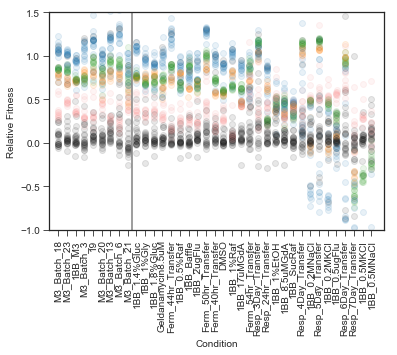

In [12]:
# test_mutant_data = this_data[~this_data['barcode'].isin(minimal_training_bcs)]

mutant_data = this_data[this_data['barcode'].isin((list(minimal_training_bcs)+list(minimal_testing_bcs)))]

train_conditions = sorted_train_cols
test_conditions = sorted_test_cols


this_gene = ['GPB2','PDE2','IRA1','Diploid','other']
# this
this_gene_data = mutant_data[mutant_data['gene'].isin(this_gene)]


this_gene_locs = np.where(np.isin(mutant_data['barcode'].values,this_gene_data['barcode'].values))[0]
jitters = [tools.jitter_point(0,0.01) for bc in range(len(this_gene_data[train_conditions[0]].values)) ]

plt.figure()
# plt.title(f'Predictions with {rank+1} components')
for i,col in enumerate(train_conditions):
    for bc in range(len(this_gene_data[col].values)):
        plt.scatter([i + 1 + jitters[bc]],this_gene_data[col].values[bc],alpha=0.1,color=mutant_colorset[this_gene_data['gene'].values[bc]]) 

for i,col in enumerate(test_conditions):
    for bc in range(len(this_gene_data[col].values)):
        plt.scatter([len(train_conditions)+i + 1 + jitters[bc]],this_gene_data[col].values[bc],alpha=0.1,color=mutant_colorset[this_gene_data['gene'].values[bc]]) 

# for gene in this_gene:
#     this_gene_data = mutant_data[mutant_data['gene']==gene]
#     data = np.median(np.asarray([this_gene_data[col].values for col in (list(train_conditions) + list(test_conditions))]),axis=1)
#     plt.plot(range(1,len((list(train_conditions) + list(test_conditions)))+1),data,alpha=1.0,color=mutant_colorset[gene],label=gene)

plt.axvline(x=len(train_conditions)+0.5,color='gray')
plt.legend()
plt.xticks(range(1,len(train_conditions)+len(test_conditions)+1),[col.split('_fitness')[0] for col in (list(train_conditions) + list(test_conditions))],rotation=90)

plt.ylim(ymin,ymax)
plt.xlim(0.0,len(train_conditions)+len(test_conditions)+1.5)
plt.ylabel('Relative Fitness')
plt.xlabel('Condition')

plt.savefig('relative_fitness_noline_dots_ylim.pdf',bbox_inches='tight')

In [13]:
# train_cols = list(sorted_train_cols) + list(sorted_test_cols[np.where(np.asarray(sorted(np.mean(test_z_scores,axis=0)))<2)[0]])
# test_cols = list(sorted_test_cols[np.where(np.asarray(sorted(np.mean(test_z_scores,axis=0)))>2)[0]])

train_cols = list(sorted_train_cols) + list(sorted_test_cols[:7])
test_cols = list(sorted_test_cols[7:])

In [14]:
mean_m3_fitness = np.mean(this_data[[col for col in sorted_train_cols]].values,axis=1)

In [15]:
m3_cols = list(sorted_train_cols)
nonm3_cols = list(sorted_test_cols)

In [16]:
this_data = merged_fitness_data
this_data = this_data.replace([np.inf, -np.inf], np.nan)
this_data = this_data.dropna('columns',how='all')
this_data = this_data.dropna()
this_data = this_data.sort_values('barcode')

best_guesses = {}

for end_point in range(2,len(nonm3_cols)-5):
    train_cols = nonm3_cols[:end_point]
    test_cols = m3_cols
    fitness_cols = train_cols + test_cols
    
    fitness = this_data[fitness_cols].values
    
    n_mutants = fitness.shape[0]
    n_conditions = fitness.shape[1]
   
    train_conditions = train_cols
    train_locs = np.where(np.isin(fitness_cols,train_conditions))[0]

    test_conditions = test_cols
    test_locs = np.where(np.isin(fitness_cols,test_conditions))[0]
    
    all_locs = sorted(list(train_locs)+list(test_locs))
    
    
    used_mutants = [bc for bc in this_data['barcode'].values if bc in (list(minimal_training_bcs) + list(minimal_testing_bcs))]
                                       
    all_mut_locs =sorted(list(np.where(np.isin(this_data['barcode'].values,used_mutants))[0]))
    
    this_fitness = fitness[all_mut_locs,:][:,all_locs]
    new_train_locs = np.where(np.isin(all_locs,train_locs))[0]
    new_test_locs = np.where(np.isin(all_locs,test_locs))[0]


    train = [new_train_locs,np.where(np.isin(used_mutants,minimal_training_bcs))[0]]
    test = [new_test_locs,np.where(np.isin(used_mutants,minimal_testing_bcs))[0]]




    # SVD predictions with all combinations of components, in parallel
    with Pool(10) as pool:
        entries = [[this_fitness,train,test,n_components,True,False,False] for n_components in range(1,end_point)]
        # (,by_condition=True,by_mutant=False)
        output = pool.starmap(tools.SVD_predictions_train_test_mixnmatch,entries)
    
    sort_list = []
    guess_list = []
    for o in output:
        sort_list.append(sorted([(o1,o2,o3) for o1,o2,o3 in zip(o[0],o[4],o[1])],reverse=True))
        guess_list.append(sorted([(o1,o2) for o1,o2 in zip(o[0],o[-1])],reverse=True))
    best_by_rank = [sort_list[rank][0][0] for rank in range(len(sort_list))]
    
    best_guesses[end_point] = (max(best_by_rank),np.where(best_by_rank==max(best_by_rank))[0][0] +1)

IndexError: list index out of range

In [ ]:
plt.plot([prediction for (prediction,rank) in best_guesses.values()])

plt.figure()

plt.plot([rank for (prediction,rank) in best_guesses.values()])

['Diploid']
['Diploid + Chr11Amp', 'Diploid + IRA1', 'Diploid + IRA2']
['IRA1']
['IRA2']
['GPB1']
['GPB2']
['PDE2']
['RAS2']
['CYR1']
['TFS1']
['KOG1']
['TOR1']
['SCH9']
['other']


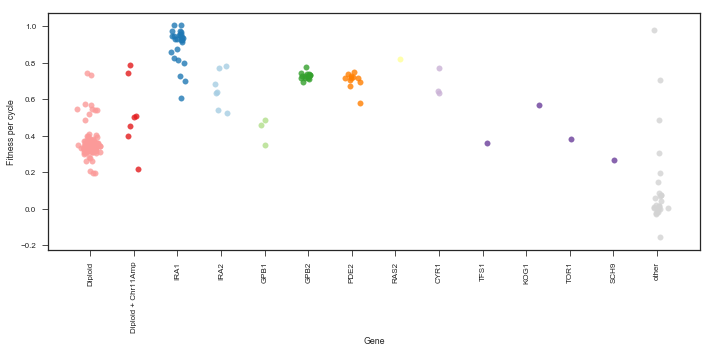

In [164]:
mutant_colorset['other'] = 'lightgray'
mutant_colorset['NotSequenced'] = 'lightgray'

sns.set(style="ticks", context="paper")
# plt.style.use("white")
all_genes = [['Diploid'], ['Diploid + Chr11Amp', 'Diploid + IRA1','Diploid + IRA2'],
                         ['IRA1'], ['IRA2'], ['GPB1'], ['GPB2'],  ['PDE2'],
                         ['RAS2'],['CYR1'],['TFS1'], ['KOG1'], ['TOR1'], ['SCH9'],['other']]

plt.figure(figsize=(10,5))
for g,gene in enumerate(all_genes):
    if type(gene) == str:
        gene = list(gene)
    print(gene)
    this_gene = this_data[this_data['gene'].isin(gene)]
    
    plt.scatter([tools.jitter_point(g,0.1) for i in range(len(this_gene.index))],this_gene['1BB_M3_fitness'].values,
               c=mutant_colorset[gene[0]],alpha=0.8)
    
    
plt.xticks(range(len(all_genes)),[gene[0] for gene in all_genes],rotation=90)
plt.ylabel('Fitness per cycle')
plt.xlabel('Gene')

plt.tight_layout()
# plt.savefig('venkataram_style_plot_dark.pdf',bbox_inches='tight')

['Diploid']
['Diploid + Chr11Amp', 'Diploid + IRA1', 'Diploid + IRA2']
['IRA1']
['IRA2']
['GPB1']
['GPB2']
['PDE2']
['Diploid']
['Diploid + Chr11Amp', 'Diploid + IRA1', 'Diploid + IRA2']
['IRA1']
['IRA2']
['GPB1']
['GPB2']
['PDE2']
['Diploid']
['Diploid + Chr11Amp', 'Diploid + IRA1', 'Diploid + IRA2']
['IRA1']
['IRA2']
['GPB1']
['GPB2']
['PDE2']
['Diploid']
['Diploid + Chr11Amp', 'Diploid + IRA1', 'Diploid + IRA2']
['IRA1']
['IRA2']
['GPB1']
['GPB2']
['PDE2']


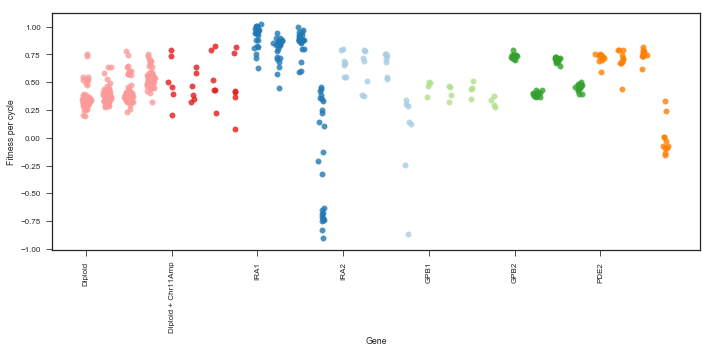

In [37]:
mutant_colorset['other'] = 'lightgray'
mutant_colorset['NotSequenced'] = 'lightgray'

sns.set(style="ticks", context="paper")
# plt.style.use("dark_background")
all_genes = [['Diploid'], ['Diploid + Chr11Amp', 'Diploid + IRA1','Diploid + IRA2'],
                         ['IRA1'], ['IRA2'], ['GPB1'], ['GPB2'],  ['PDE2'],
#                          ['RAS2'],['CYR1'],['TFS1'], ['KOG1'], ['TOR1'], ['SCH9'],['other']
            ]

plt.figure(figsize=(10,5))
for g,gene in enumerate(all_genes):
    if type(gene) == str:
        gene = list(gene)
    print(gene)
    this_gene = this_data[this_data['gene'].isin(gene)]
    
    plt.scatter([tools.jitter_point(g,0.02) for i in range(len(this_gene.index))],this_gene['1BB_M3_fitness'].values,
               c=mutant_colorset[gene[0]],alpha=0.8)

for c,condition in enumerate(['24_Hour_Transfer_PC','1BB_1.8%Gluc','1BB_0.2MKCl']):
    for g,gene in enumerate(all_genes):
        if type(gene) == str:
            gene = list(gene)
        print(gene)
        this_gene = this_data[this_data['gene'].isin(gene)]

        plt.scatter([tools.jitter_point(g+0.25*(c+1),0.02) for i in range(len(this_gene.index))],this_gene[condition+'_fitness'].values,
                   c=mutant_colorset[gene[0]],alpha=0.8)
    
    
plt.xticks(range(len(all_genes)),[gene[0] for gene in all_genes],rotation=90)
plt.ylabel('Fitness per cycle')
plt.xlabel('Gene')

plt.tight_layout()
# plt.savefig('venkataram_style_plot_dark_m3_2mkcl.pdf',bbox_inches='tight')